<img src="Imagenes/banner_grupos.jpg" alt="Imagen creada con inteligencia artificial y editada con Microsoft Paint" style="border-radius: 15px; width: 1500px; height: 500px;">


*Imagen creada con inteligencia artificial.*


## **BIBLIOTECAS USADAS:**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image 
import math

## **INTRODUCCIÓN**

En este **Jupyter Notebook** se realizará una **visualización** y un pequeño **EDA** del dataset obtenido al transformar la colección de fotografías de "**AffectNet**" en un archivo **CSV** con un formato similar al de "**FER-2013**". Este dataset se utilizará para concatenarlo con '**FER2013**' y entrenar un modelo de reconocimiento de expresiones faciales. El objetivo es mejorar la **solidez** del modelo y su capacidad de **generalización**.

El dataset original contiene más de **1 millón** de imágenes faciales etiquetadas con emociones como **alegría**, **tristeza**, **enojo**, **sorpresa**, **miedo**, **disgusto**, **neutralidad** y otras. Es utilizado para entrenar modelos de reconocimiento de emociones en inteligencia artificial y es ampliamente utilizado en **investigación académica** y aplicaciones **industriales**.

**AffectNet** fue creado por **Mohammad Soleymani** y otros colaboradores. Fue publicado por primera vez en **2017** y desde entonces ha sido una referencia clave en el campo del reconocimiento de emociones en imágenes faciales.


## **CARGA DEL DASET**

In [2]:
df = pd.read_csv('./datos/AffectNet/df_AffectNet_formato.csv')

## **PEQUEÑA VISUALIZACIÓN DEL DATA SET**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26171 entries, 0 to 26170
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  26171 non-null  int64 
 1   pixels   26171 non-null  object
 2   Usage    26171 non-null  object
dtypes: int64(1), object(2)
memory usage: 613.5+ KB


>Vemos que hay 22953 entradas o filas, es decir, 22953 fotografías; ninguna columna tiene nulos."

In [4]:
print("Primeras filas del dataframe:")
df.head(5)

Primeras filas del dataframe:


,emotion,pixels,Usage
0,0,75 66 50 38 25 35 52 44 65 71 102 65 71 59 90 ...,Training
1,0,255 255 255 255 255 255 255 255 255 38 62 27 1...,Training
2,0,121 124 127 127 125 119 121 122 128 115 54 32 ...,Training
3,0,2 20 47 39 32 32 36 35 35 33 32 40 81 204 227 ...,Training
4,0,73 86 122 142 160 178 188 192 192 73 66 76 70 ...,Training


In [5]:
df['emotion'].value_counts()

emotion
6    5126
3    5044
5    4039
0    3218
2    3176
4    3091
1    2477
Name: count, dtype: int64

## **ESTUDIO DE LAS COLUMNAS** 
### La columna 'emotion', es la columna objetivo.

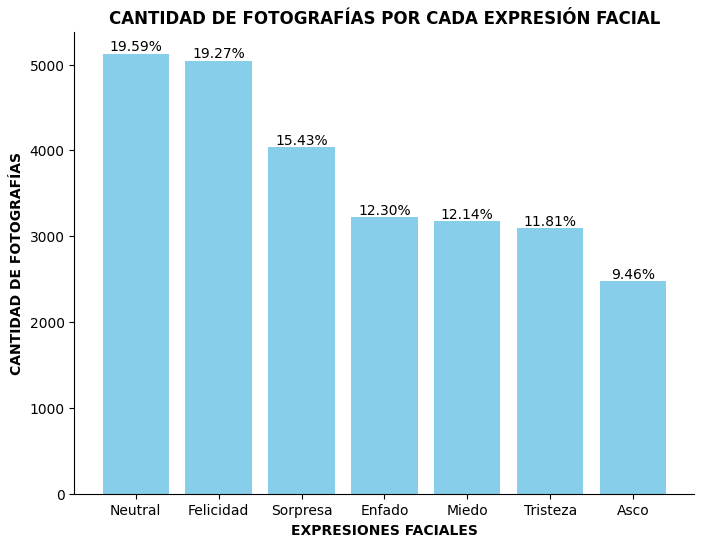

In [6]:

emotion_labels = {0: 'Enfado',1: 'Asco',2: 'Miedo',3: 'Felicidad',4: 'Tristeza',5: 'Sorpresa',6: 'Neutral'}

value_counts = df['emotion'].value_counts()
value_counts.index = value_counts.index.map(emotion_labels)
percentages = (value_counts / value_counts.sum()) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts, color='skyblue')
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')
plt.title('CANTIDAD DE FOTOGRAFÍAS POR CADA EXPRESIÓN FACIAL', fontweight='bold')
plt.xlabel('EXPRESIONES FACIALES', fontweight='bold')
plt.ylabel('CANTIDAD DE FOTOGRAFÍAS', fontweight='bold')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xticks(rotation=0)  
plt.show()

In [9]:
df['emotion'].value_counts()

emotion
6    5126
3    5044
5    4039
0    3218
2    3176
4    3091
1    2477
Name: count, dtype: int64

>**AffectNet**, al menos la versión con la que estamos trabajando, tampoco está balanceada, aunque este **desbalanceo** no es tan acusado como en **“FER2013”**.


> Al final del notebook estudiaremos algo más en profundidad este **desbalanceo**.
>
> Para el **etiquetado** cambiamos los nombres de las carpetas que contenían las fotografías, las cuales usamos para crear el **dataframe**, por su correspondiente clave.
>


### **Columna 'Usage'**
>Esta columna propone el uso (entrenamiento o uno de los dos test) para cada fila del dataframe, es decir, para cada fotografia.  
>   
> Esta columna fue creada asignando de forma aleatoria las claves para **entrenamiento** (80%), **validación** (10%) y **prueba** (10%).


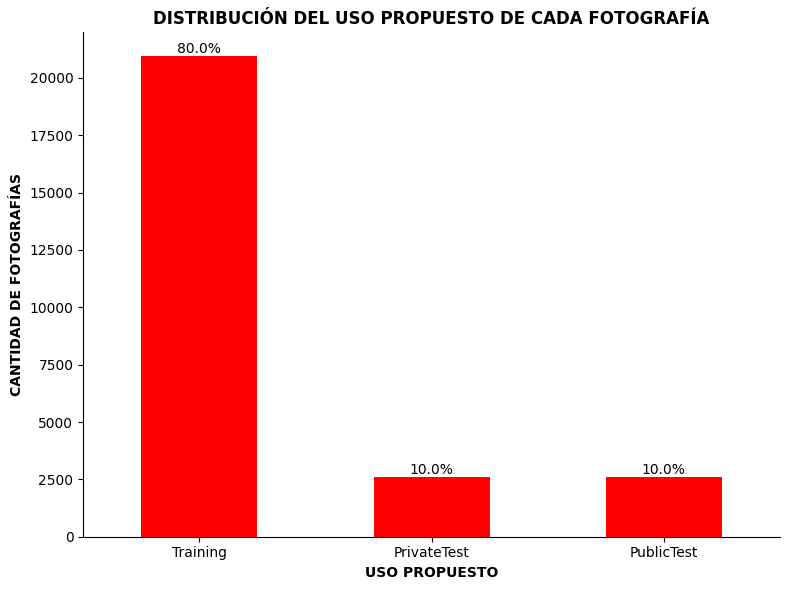

In [10]:
plt.figure(figsize=(8, 6))
value_counts = df['Usage'].value_counts()
percentages = value_counts / len(df) * 100
bars = value_counts.plot(kind='bar', color='RED')
plt.title('DISTRIBUCIÓN DEL USO PROPUESTO DE CADA FOTOGRAFÍA', fontweight='bold')
plt.xlabel('USO PROPUESTO', fontweight='bold')
plt.ylabel('CANTIDAD DE FOTOGRAFÍAS', fontweight='bold')
for i, (category, count) in enumerate(value_counts.items()):
    plt.text(i, count + 0.5, f'{percentages[category]:.1f}%', ha='center', va='bottom', fontsize=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [11]:
df['Usage'].value_counts()

Usage
Training       20940
PrivateTest     2618
PublicTest      2613
Name: count, dtype: int64

> La partición fue bien, tenemos un 80% para entrenar el modelo, un 10% para validarlo y otro 10% para probarlo. En cuanto al reparto por etiquetas de forma individual, dado que se hizo de uno en uno, estará bien.


### **Columna 'pixels'**
> Esta columna está compuesta, al igual que en **‘FER2013’**, por cadenas (strings) de números, representando los colores de los píxeles.  
> Para el estudio de la columna nos centraremos en las características de las imágenes.


## **CARACTERISTICAS DE LAS IMAGENES**

In [12]:
# Obtener el tamaño en píxeles de las imágenes
df['num_pixels'] = df['pixels'].apply(lambda x: len(x.split()))

# Calcular estadísticas sobre el tamaño en píxeles
min_pixels = df['num_pixels'].min()
max_pixels = df['num_pixels'].max()


print(f"Tamaño mínimo de imagen en píxeles: {min_pixels}")
print(f"Tamaño máximo de imagen en píxeles: {max_pixels}")

print(f"Por lo que las imagenes son de {int(math.sqrt(max_pixels))}x{int(math.sqrt(max_pixels))} ")


Tamaño mínimo de imagen en píxeles: 2304
Tamaño máximo de imagen en píxeles: 2304
Por lo que las imagenes son de 48x48 


> Parece que el trabajo de transformación fue bien, todas las imágenes están ahora en formato 48x48 píxeles. Nos queda por ver el color.


In [13]:
ejemplo_pixels = df['pixels'].iloc[0] #Sabemos que todas las filas, tienen las misma caracteristicas, asi que cogemos una cualquiera.

# Dividimos la cadena de píxeles en valores individuales y convertimos a enteros
valores_pixeles = list(map(int, ejemplo_pixels.split()))

# Verificamos si todos los valores están dentro del rango de 0 a 255
todos_en_rango = all(0 <= pixel <= 255 for pixel in valores_pixeles)

if todos_en_rango:
    print("Las imágenes del dataset 'FER2013' son en escala de grises.")
else:
    print("Las imágenes del dataset 'FER2013' son a color (o tienen valores fuera del rango 0-255).")

Las imágenes del dataset 'FER2013' son en escala de grises.


> Sí, la transformación a escala de grises también fue bien.


## **VISUALIZACIÓN DE LAS IMAGENES** 
> Esta es la comprobación más importante, ¿no crees?


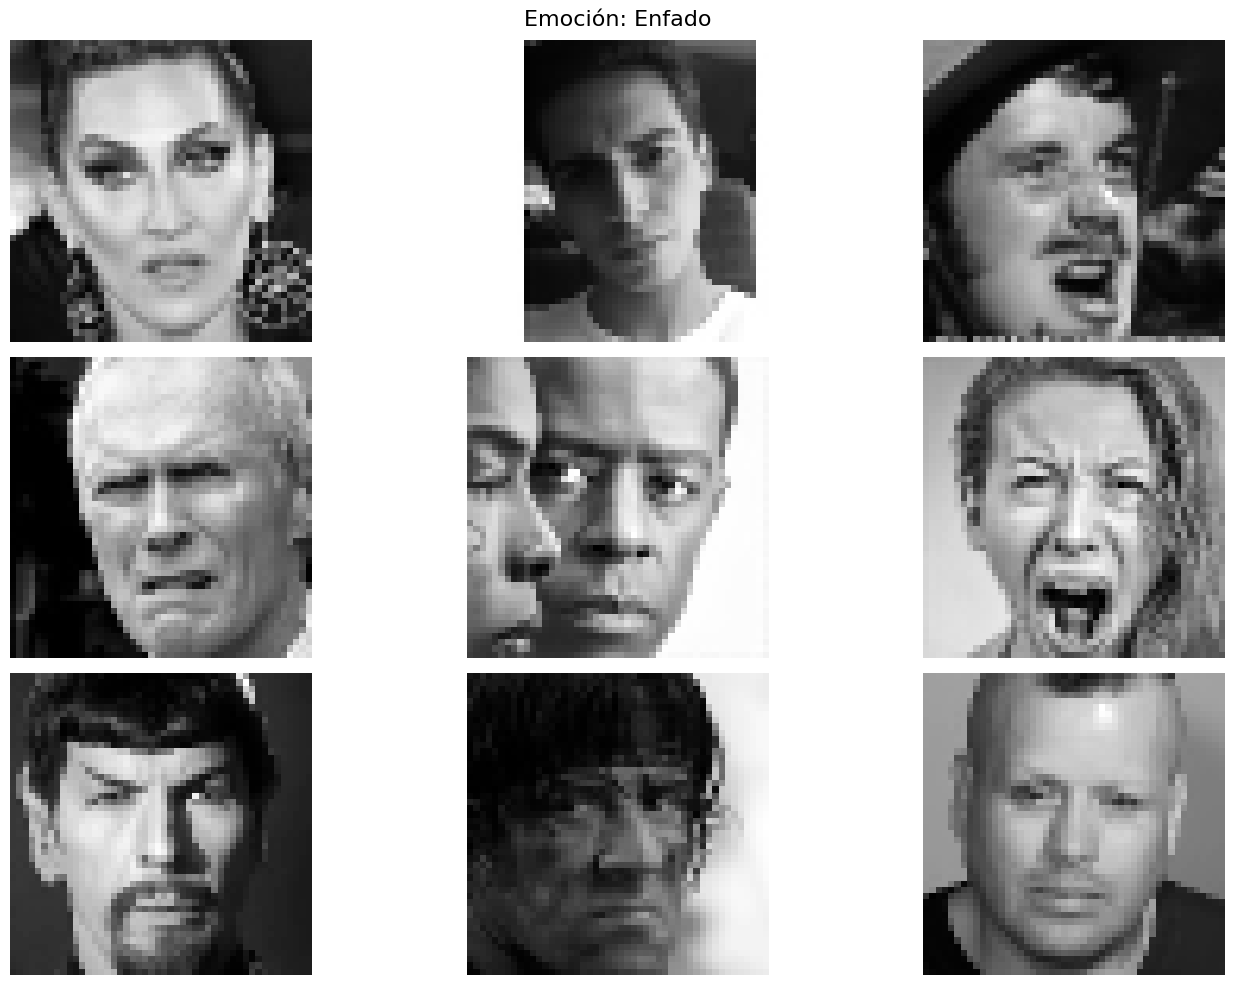

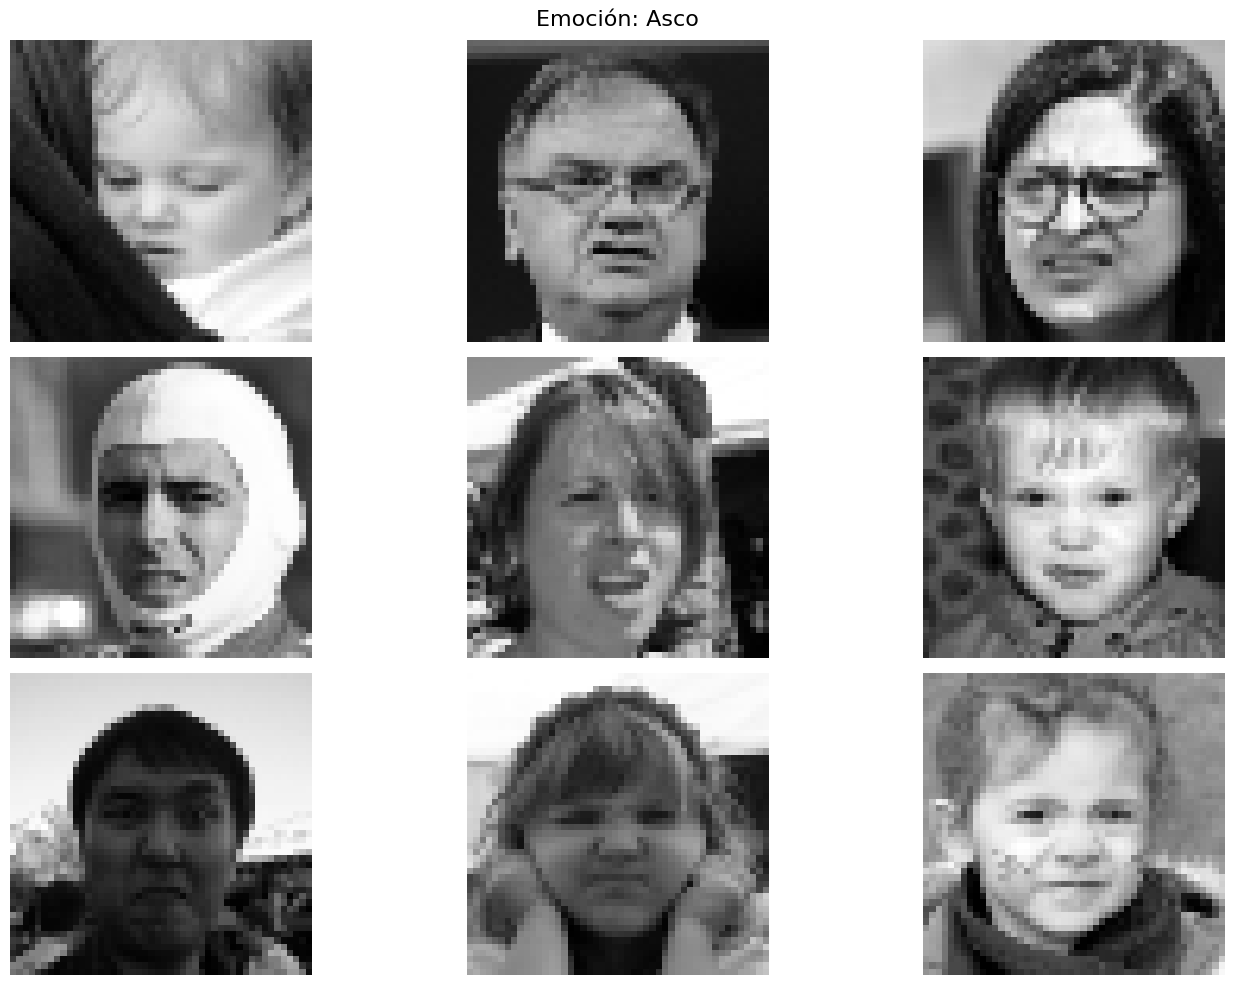

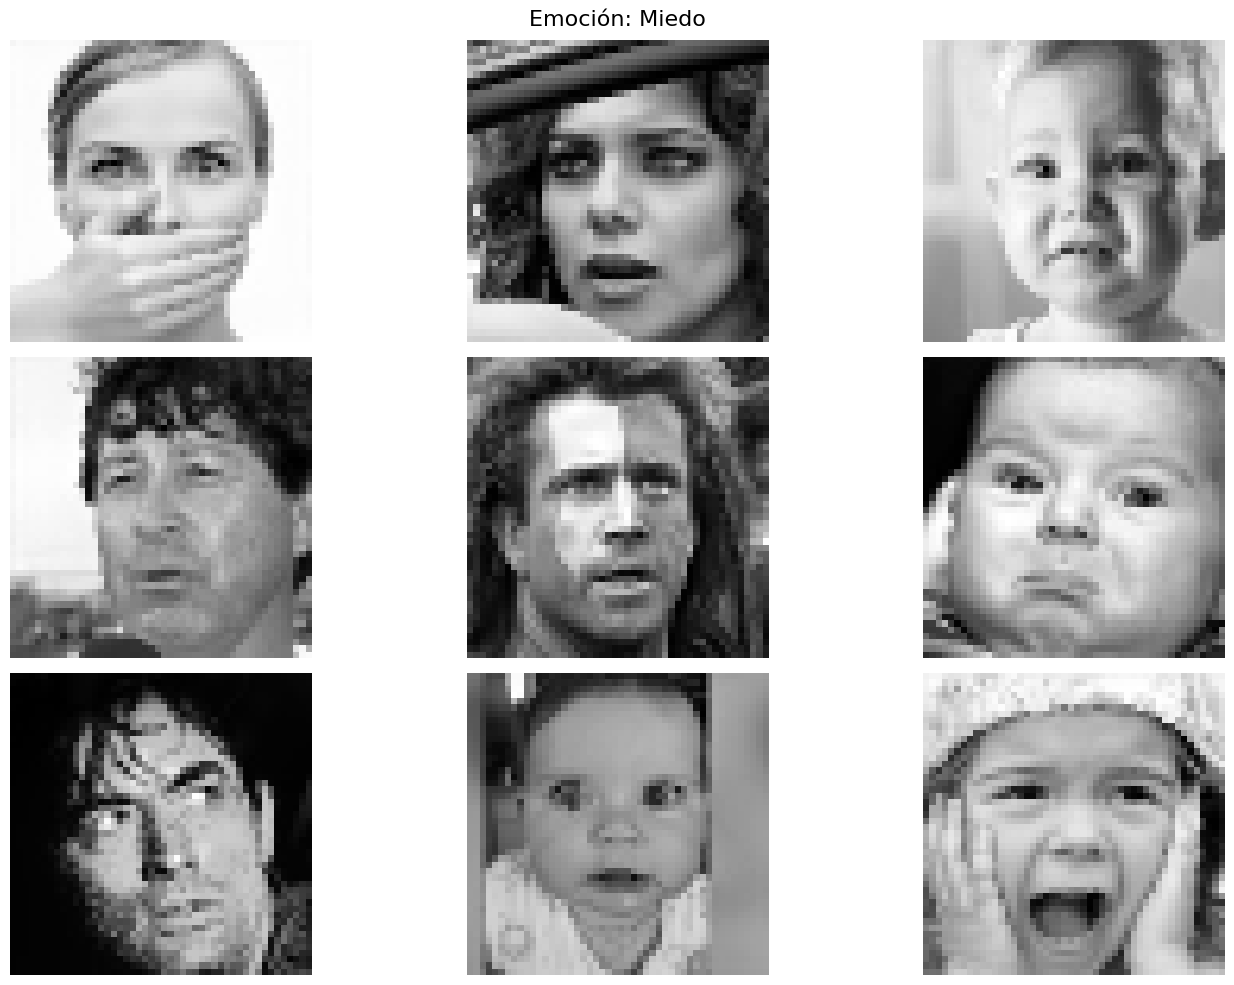

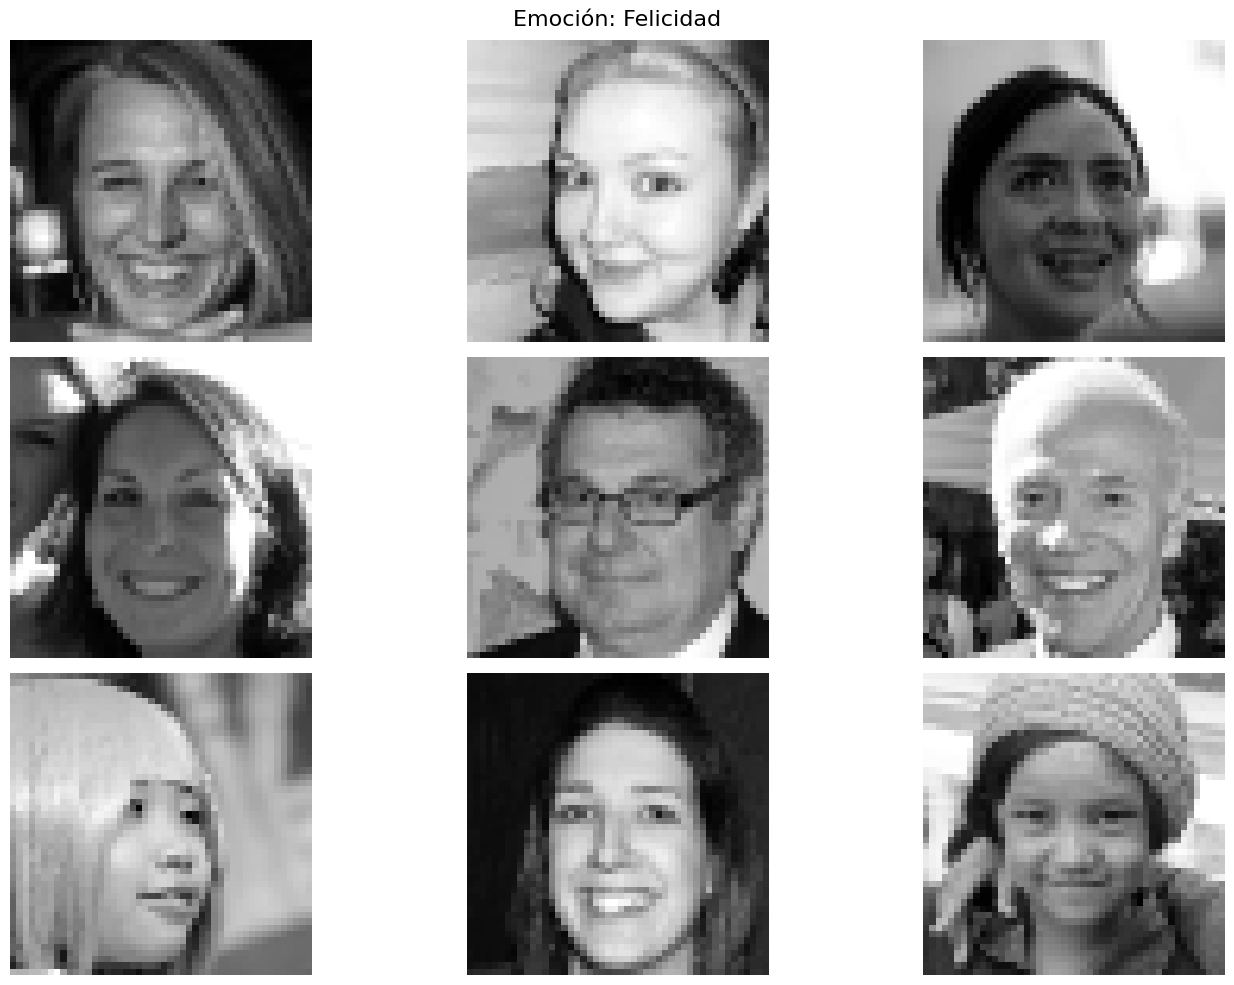

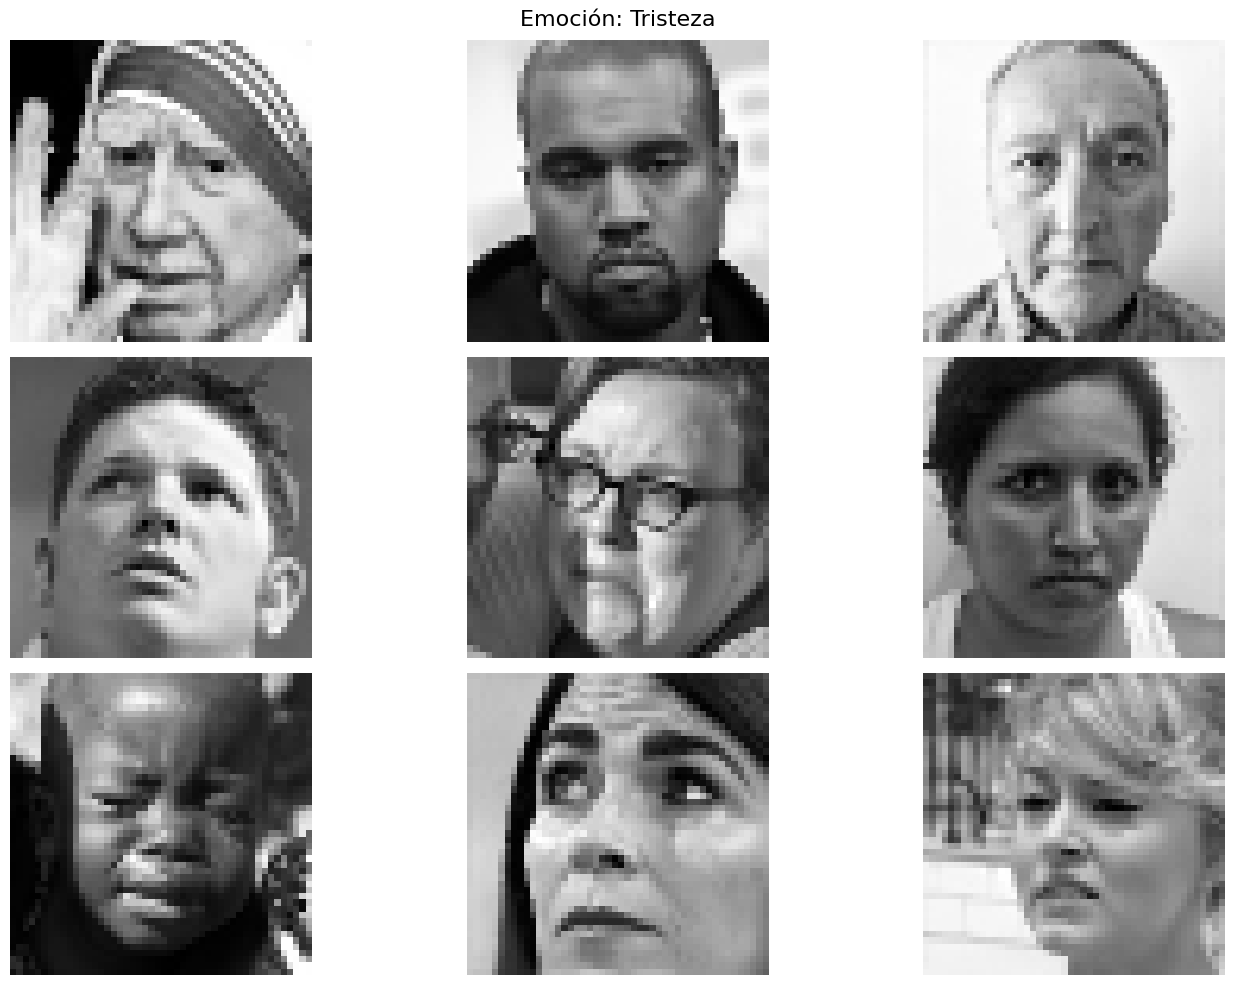

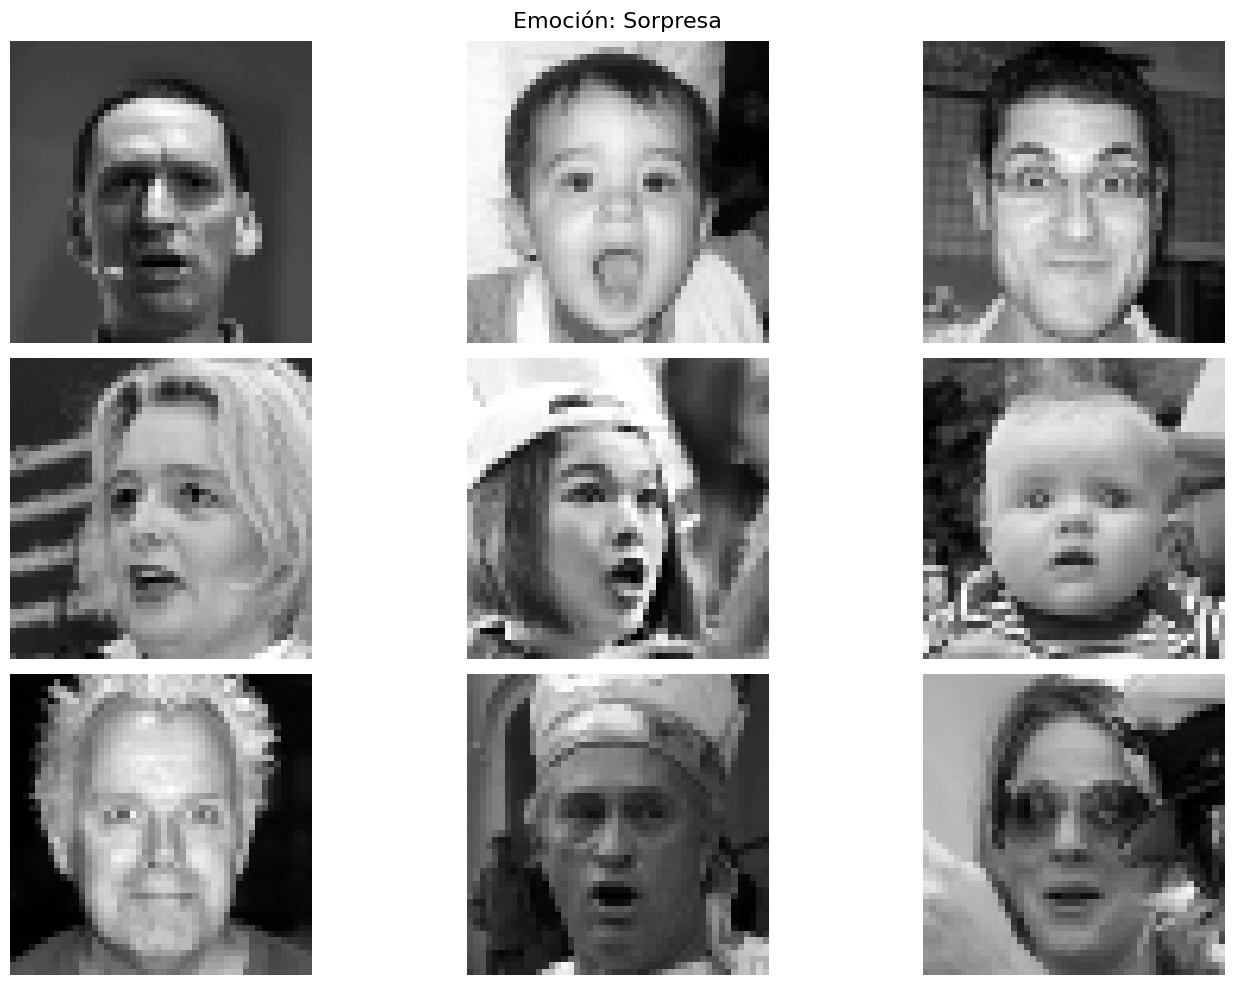

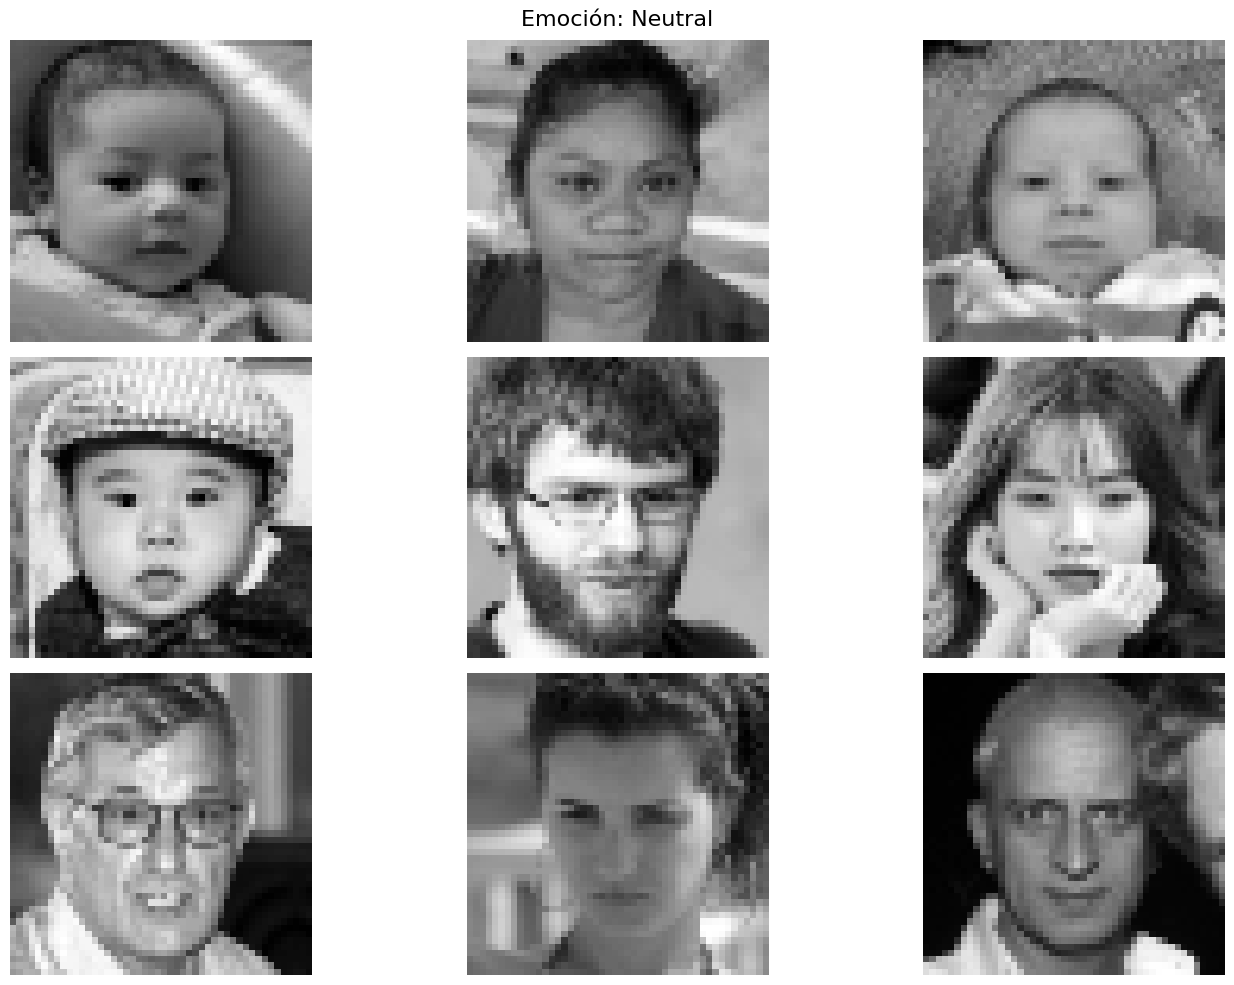

In [14]:
def mostrar_imagenes_emocion(emotion):
    filtered_df = df[df['emotion'] == emotion].head(9)

    # Configurar la visualización de las imágenes en 3 columnas
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()


for emotion in range(7):  # Hay 7 emociones en total (0 a 6)
    mostrar_imagenes_emocion(emotion)

> ## **¡ANDA PARECE QUE VAMOS BIEN!** 🥳🎉

## **ESTUDIO INDIVIDUAL DE LA COLUMNA 'emotion' POR CADA USO** 
### **Esto es importante de cara al correcto balanceado.**  
> ### Tenemos datasets individuales de cada expresión facial. Ahora necesitamos tres datasets: uno de entrenamiento, otro de validación y otro de pruebas, cada uno con todas las expresiones faciales.


In [15]:
df_train = df[df['Usage'] == 'Training'].copy() #Usamos 'copy()' para evitar advertencias y asegurar modificaciones seguras en los DataFrames derivados.
df_test = df[df['Usage'] == 'PublicTest'].copy()
df_val = df[df['Usage'] == 'PrivateTest'].copy()


df_train.drop(columns=['num_pixels'], inplace=True)
df_test.drop(columns=['num_pixels'], inplace=True)
df_val.drop(columns=['num_pixels'], inplace=True) 

In [16]:
print("Número de filas en df_train:", len(df_train))
print("Número de filas en df_test:", len(df_test))
print("Número de filas en df_val:", len(df_val))

Número de filas en df_train: 20940
Número de filas en df_test: 2613
Número de filas en df_val: 2618


## **TRAIN**

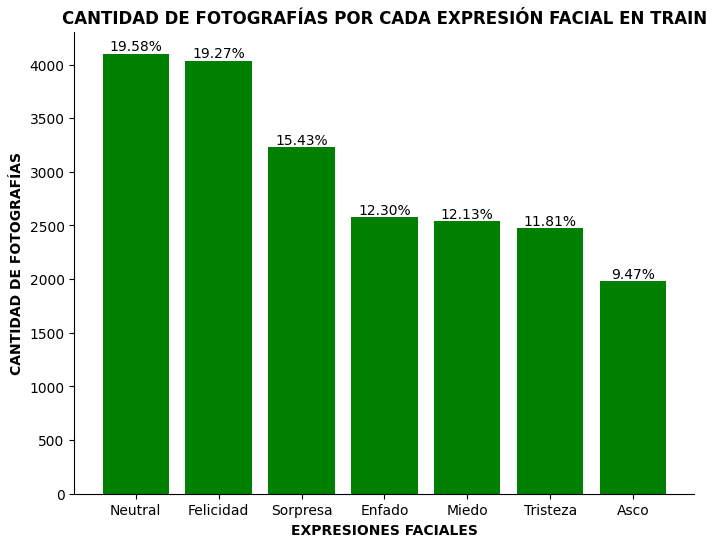

In [21]:
value_counts_train = df_train['emotion'].value_counts()
value_counts_train.index = value_counts_train.index.map(emotion_labels)
percentages_train = (value_counts_train / value_counts_train.sum()) * 100

plt.figure(figsize=(8, 6))
bars_train = plt.bar(value_counts_train.index, value_counts_train, color='GREEN')
for bar_train, percentage_train in zip(bars_train, percentages_train):
    height_train = bar_train.get_height()
    plt.text(bar_train.get_x() + bar_train.get_width() / 2, height_train, f'{percentage_train:.2f}%', ha='center', va='bottom')
plt.title('CANTIDAD DE FOTOGRAFÍAS POR CADA EXPRESIÓN FACIAL EN TRAIN', fontweight='bold')
plt.xlabel('EXPRESIONES FACIALES', fontweight='bold')
plt.ylabel('CANTIDAD DE FOTOGRAFÍAS', fontweight='bold')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xticks(rotation=0)  
plt.show()

## **TEST**

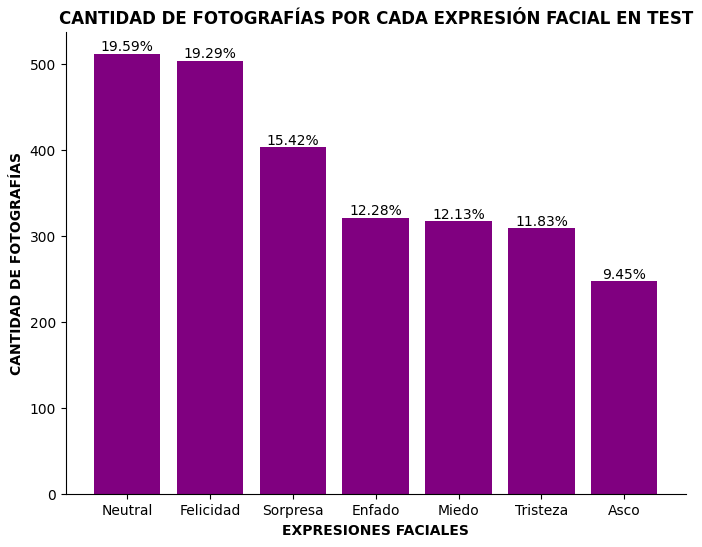

In [19]:
value_counts_test = df_test['emotion'].value_counts()
value_counts_test.index = value_counts_test.index.map(emotion_labels)
percentages_test = (value_counts_test / value_counts_test.sum()) * 100

plt.figure(figsize=(8, 6))
bars_test = plt.bar(value_counts_test.index, value_counts_test, color='PURPLE')
for bar_test, percentage_test in zip(bars_test, percentages_test):
    height_test = bar_test.get_height()
    plt.text(bar_test.get_x() + bar_test.get_width() / 2, height_test, f'{percentage_test:.2f}%', ha='center', va='bottom')
plt.title('CANTIDAD DE FOTOGRAFÍAS POR CADA EXPRESIÓN FACIAL EN TEST', fontweight='bold')
plt.xlabel('EXPRESIONES FACIALES', fontweight='bold')
plt.ylabel('CANTIDAD DE FOTOGRAFÍAS', fontweight='bold')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xticks(rotation=0)  
plt.show()

## **VALIDACIÓN**

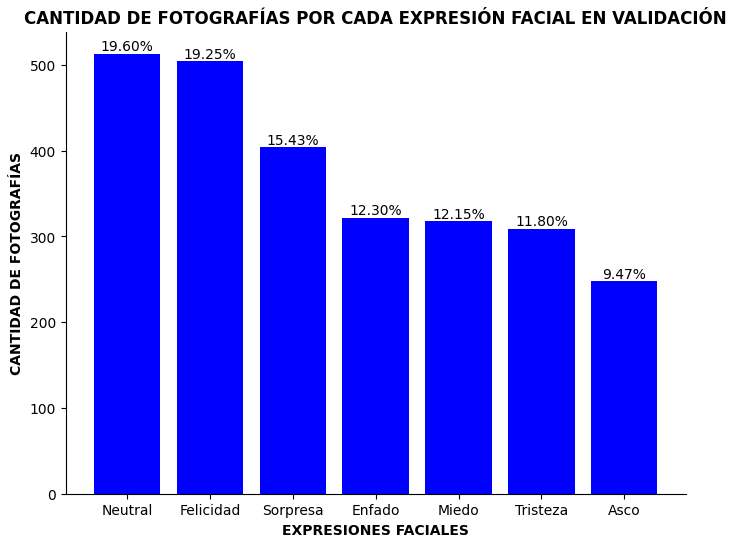

In [20]:
value_counts_val = df_val['emotion'].value_counts()
value_counts_val.index = value_counts_val.index.map(emotion_labels)
percentages_val = (value_counts_val / value_counts_val.sum()) * 100

plt.figure(figsize=(8, 6))
bars_val = plt.bar(value_counts_val.index, value_counts_val, color='blue')
for bar_val, percentage_val in zip(bars_val, percentages_val):
    height_val = bar_val.get_height()
    plt.text(bar_val.get_x() + bar_val.get_width() / 2, height_val, f'{percentage_val:.2f}%', ha='center', va='bottom')
plt.title('CANTIDAD DE FOTOGRAFÍAS POR CADA EXPRESIÓN FACIAL EN VALIDACIÓN', fontweight='bold')
plt.xlabel('EXPRESIONES FACIALES', fontweight='bold')
plt.ylabel('CANTIDAD DE FOTOGRAFÍAS', fontweight='bold')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xticks(rotation=0)  
plt.show()

## **TODOS**

In [22]:

print("El reparto en el dataset original:")
print(df['emotion'].value_counts(normalize=True) * 100) 
print()
print("El reparto en el dataset de entrenamiento:")
print(df_train['emotion'].value_counts(normalize=True) * 100)
print()
print("El reparto en el dataset de test:")
print(df_test['emotion'].value_counts(normalize=True) * 100)
print()
print("El reparto en el dataset de validación:")
print(df_val['emotion'].value_counts(normalize=True) * 100)

El reparto en el dataset original:
emotion
6    19.586565
3    19.273241
5    15.433113
0    12.296053
2    12.135570
4    11.810783
1     9.464675
Name: proportion, dtype: float64

El reparto en el dataset de entrenamiento:
emotion
6    19.584527
3    19.274117
5    15.434575
0    12.297039
2    12.134670
4    11.809933
1     9.465138
Name: proportion, dtype: float64

El reparto en el dataset de test:
emotion
6    19.594336
3    19.288175
5    15.422886
0    12.284730
2    12.131649
4    11.825488
1     9.452736
Name: proportion, dtype: float64

El reparto en el dataset de validación:
emotion
6    19.595111
3    19.251337
5    15.431627
0    12.299465
2    12.146677
4    11.802903
1     9.472880
Name: proportion, dtype: float64


>Los repartos de cada expresión son muy similares en cada una de las 3 partes.


## **GUARDADO DE LOS DATASETS**
>**Para facilitar un poco las cosas en el notebook de 'data augmentation_AffectNet', guardaremos los datasets individuales.**

In [23]:
df_train.to_csv('datos/AffectNet/df_train_aff.csv', index=False)
df_test.to_csv('datos/AffectNet/df_test_aff.csv', index=False)
df_val.to_csv('datos/AffectNet/df_val_aff.csv', index=False)